In [1]:
#Import the libraries
import math
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout
import matplotlib.pyplot as plt
import datetime

c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\yfinance\base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


In [2]:
start = '2000-01-01'
end = '2024-01-01'
stock = 'AAPL'

df = yf.download(stock, start, end)
df.reset_index(inplace=True)
df

[*********************100%%**********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-03,0.936384,1.004464,0.907924,0.999442,0.846127,535796800
1,2000-01-04,0.966518,0.987723,0.903460,0.915179,0.774790,512377600
2,2000-01-05,0.926339,0.987165,0.919643,0.928571,0.786128,778321600
3,2000-01-06,0.947545,0.955357,0.848214,0.848214,0.718097,767972800
4,2000-01-07,0.861607,0.901786,0.852679,0.888393,0.752113,460734400
...,...,...,...,...,...,...,...
6032,2023-12-22,195.179993,195.410004,192.970001,193.600006,193.353287,37122800
6033,2023-12-26,193.610001,193.889999,192.830002,193.050003,192.803986,28919300
6034,2023-12-27,192.490005,193.500000,191.089996,193.149994,192.903839,48087700
6035,2023-12-28,194.139999,194.660004,193.169998,193.580002,193.333298,34049900


In [3]:
#Get the number of rows and columns

df.shape

(6037, 7)

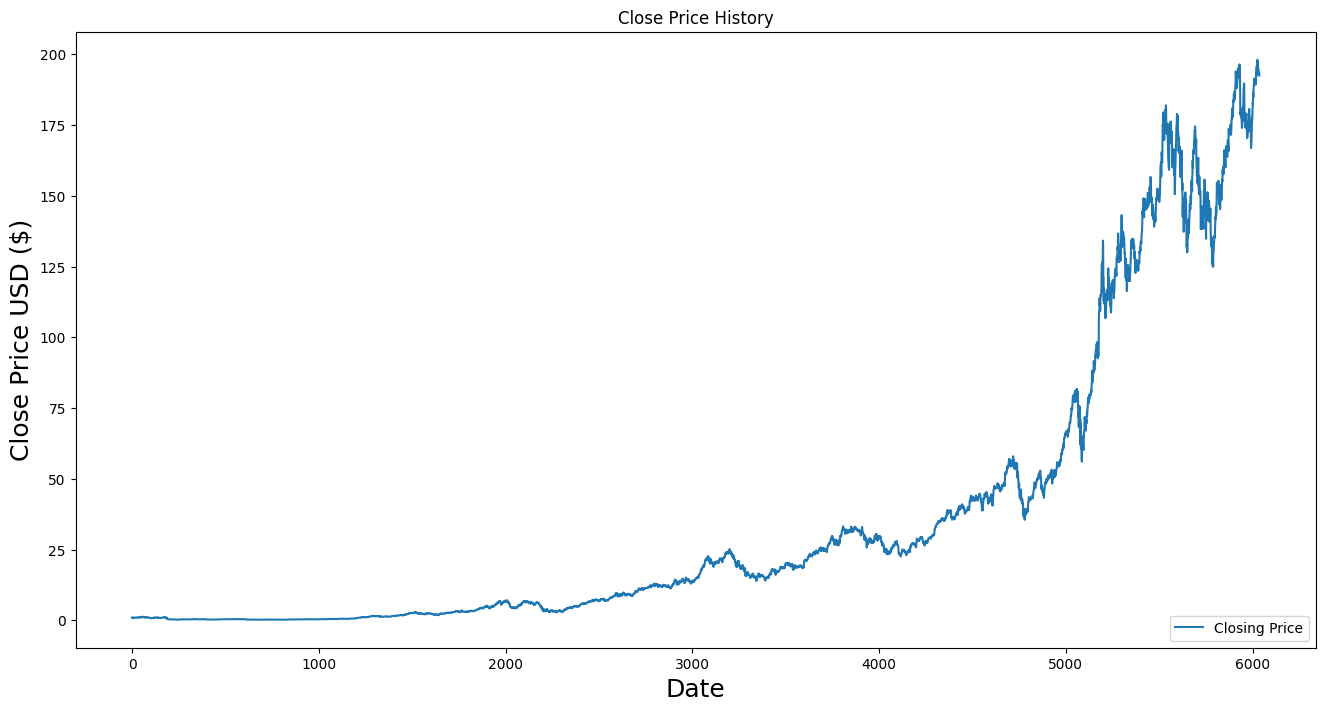

In [4]:
#Visualize the closing price history
plt.figure(figsize=(16,8))
plt.title("Close Price History")
plt.plot(df['Close'])
plt.xlabel("Date",fontsize=18)
plt.ylabel("Close Price USD ($)",fontsize=18)
plt.legend(['Closing Price'],loc = "lower right")
plt.show()

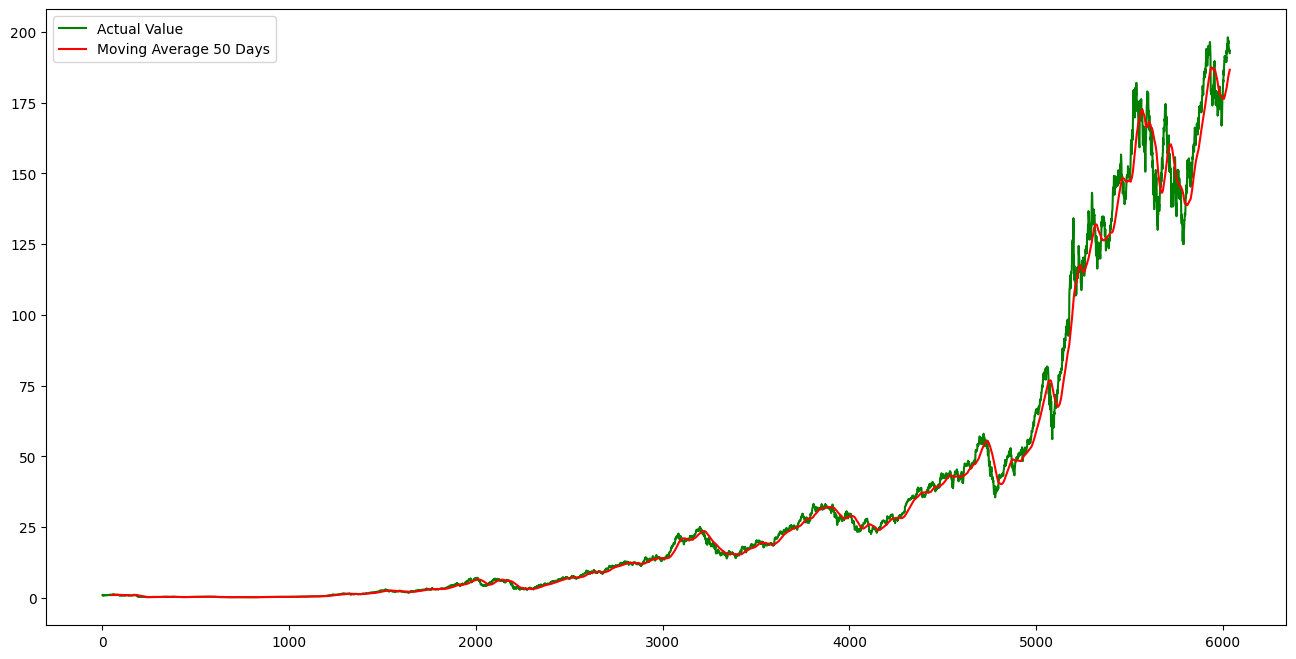

In [5]:
ma_50_days = df.Close.rolling(50).mean()
plt.figure(figsize=(16,8))
plt.plot(df.Close, 'g')
plt.plot(ma_50_days, 'r')
plt.legend(['Actual Value','Moving Average 50 Days'],loc = 'upper left')
plt.show()

In [6]:
ma_100_days = df.Close.rolling(100).mean()

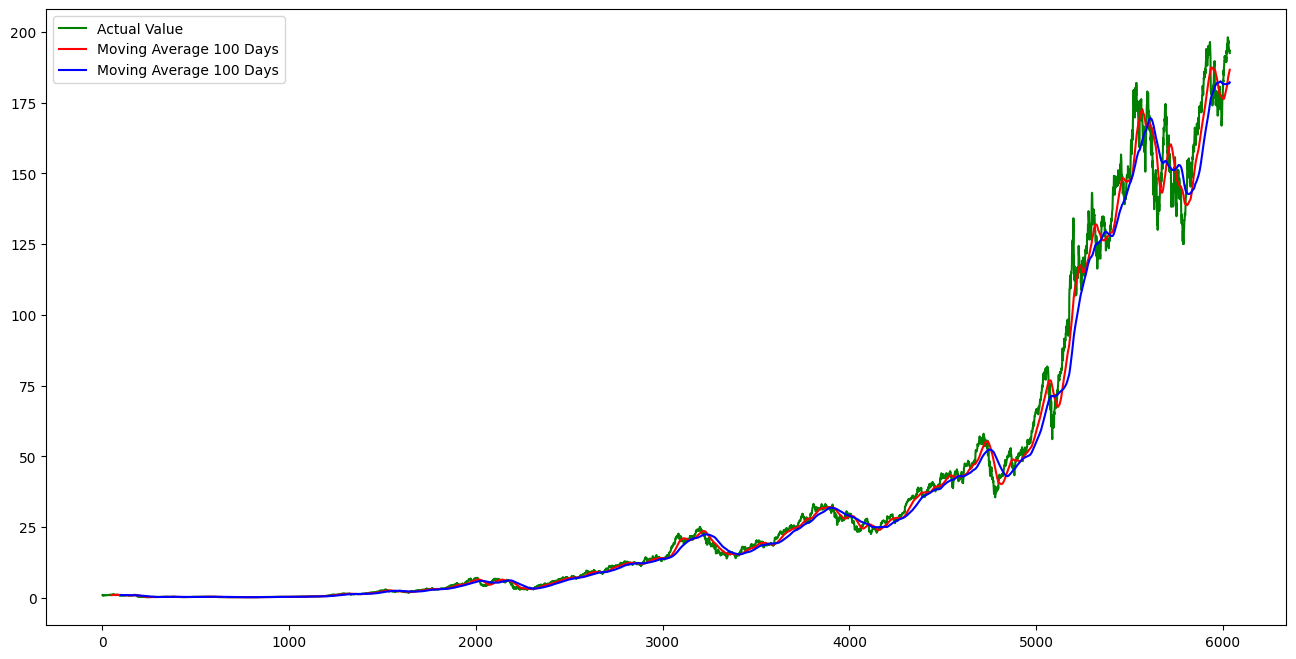

In [7]:
plt.figure(figsize=(16,8))
plt.plot(df.Close, 'g')
plt.plot(ma_50_days, 'r')
plt.plot(ma_100_days, 'b')
plt.legend(['Actual Value','Moving Average 100 Days','Moving Average 100 Days'],loc = 'upper left')
plt.show()

In [9]:
#Create a new dataframe with only the Close column
data = df.filter(['Close'])
#Convert a dataframe to a numpy array
dataset = data.values
#Get the number of rows to train the model on
training_data_len = math.ceil(len(dataset) * .8);
training_data_len

4830

In [10]:
#Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.00386685],
       [0.00344101],
       [0.00350869],
       ...,
       [0.97493373],
       [0.97710685],
       [0.97180047]])

In [11]:
#Create the training data set
#Create the scaled training data set
train_data = scaled_data[0:training_data_len,:]
#Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(100,len(train_data)):
  x_train.append(train_data[i-100:i,0])
  y_train.append(train_data[i,0])
  if i <= 100:
    print(x_train)
    print(y_train)
    print()

[array([0.00386685, 0.00344101, 0.00350869, 0.00310259, 0.00330565,
       0.00322668, 0.00300107, 0.00275008, 0.00318156, 0.00334795,
       0.00350587, 0.00362432, 0.00393736, 0.00383865, 0.00361022,
       0.00388095, 0.00378789, 0.00377943, 0.00340153, 0.00349741,
       0.00333948, 0.00327462, 0.00347767, 0.00368918, 0.00396273,
       0.0039994 , 0.00389787, 0.00393736, 0.00372302, 0.0040417 ,
       0.00418553, 0.00396555, 0.0039994 , 0.00383583, 0.00395146,
       0.00406144, 0.0040142 , 0.00379635, 0.00392608, 0.00398812,
       0.00469597, 0.00432089, 0.00459162, 0.00448728, 0.00436037,
       0.00432089, 0.00433217, 0.0044901 , 0.00428987, 0.00397119,
       0.00406144, 0.00430115, 0.00445626, 0.00436601, 0.00490466,
       0.00532204, 0.00519231, 0.00507387, 0.00511335, 0.00509361,
       0.00494978, 0.0044901 , 0.00494414, 0.00483134, 0.00456061,
       0.00469879, 0.00446472, 0.00476083, 0.00445626, 0.00420527,
       0.00374558, 0.00395146, 0.00386403, 0.0044055 , 0.0045

In [12]:
#Convert the x_train and y_train to numpy arrays
x_train,y_train = np.array(x_train),np.array(y_train)

In [13]:
#Reshape the data
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1], 1))
x_train.shape

(4730, 100, 1)

In [14]:
#Build the LSTM Model
model = Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(50,return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [15]:
#Compile the model
model.compile(optimizer='adam',loss='mean_squared_error',metrics=['accuracy'])

In [16]:
model.fit(x_train,y_train, epochs = 50, batch_size =32, verbose = 1)

Epoch 1/50

148/148 [==============================] - 16s 71ms/step - loss: 3.6438e-04
Epoch 2/50
148/148 [==============================] - 11s 76ms/step - loss: 1.5602e-05
Epoch 3/50
148/148 [==============================] - 10s 71ms/step - loss: 1.8851e-05
Epoch 4/50
148/148 [==============================] - 11s 75ms/step - loss: 1.5734e-05
Epoch 5/50
148/148 [==============================] - 10s 66ms/step - loss: 1.5849e-05
Epoch 6/50
148/148 [==============================] - 10s 69ms/step - loss: 1.3553e-05
Epoch 7/50
148/148 [==============================] - 12s 78ms/step - loss: 1.3833e-05
Epoch 8/50
148/148 [==============================] - 11s 74ms/step - loss: 1.5099e-05
Epoch 9/50
148/148 [==============================] - 11s 74ms/step - loss: 1.2306e-05
Epoch 10/50
148/148 [==============================] - 11s 77ms/step - loss: 1.4142e-05
Epoch 11/50
148/148 [==============================] - 12s 78ms/step - loss: 1.1080e-05
Epoch 12/50
148/148 [===================

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 25)                1275      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 31901 (124.61 KB)
Trainable params: 31901 (124.61 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [18]:
#Create the testing dataset
#Create a new array containing scaled values
test_data = scaled_data[training_data_len - 100: , :]
#Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len: , :]

for i in range(100,len(test_data)):
  x_test.append(test_data[i-100:i,0])

In [19]:
#Convert the data into a numpy array
x_test = np.array(x_test)
x_test.shape

(1207, 100)

In [20]:
#Reshape the data
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))
# x_test.shape
y_test.shape

(1207, 1)

In [21]:
#Get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
predictions.shape

38/38 [==============================] - 2s 23ms/step


(1207, 1)

In [22]:
#Get the root mean squared error(RMSE)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

2.413313115838153

Mean Absolute Percentage Error (MAPE): 2.148809891979711


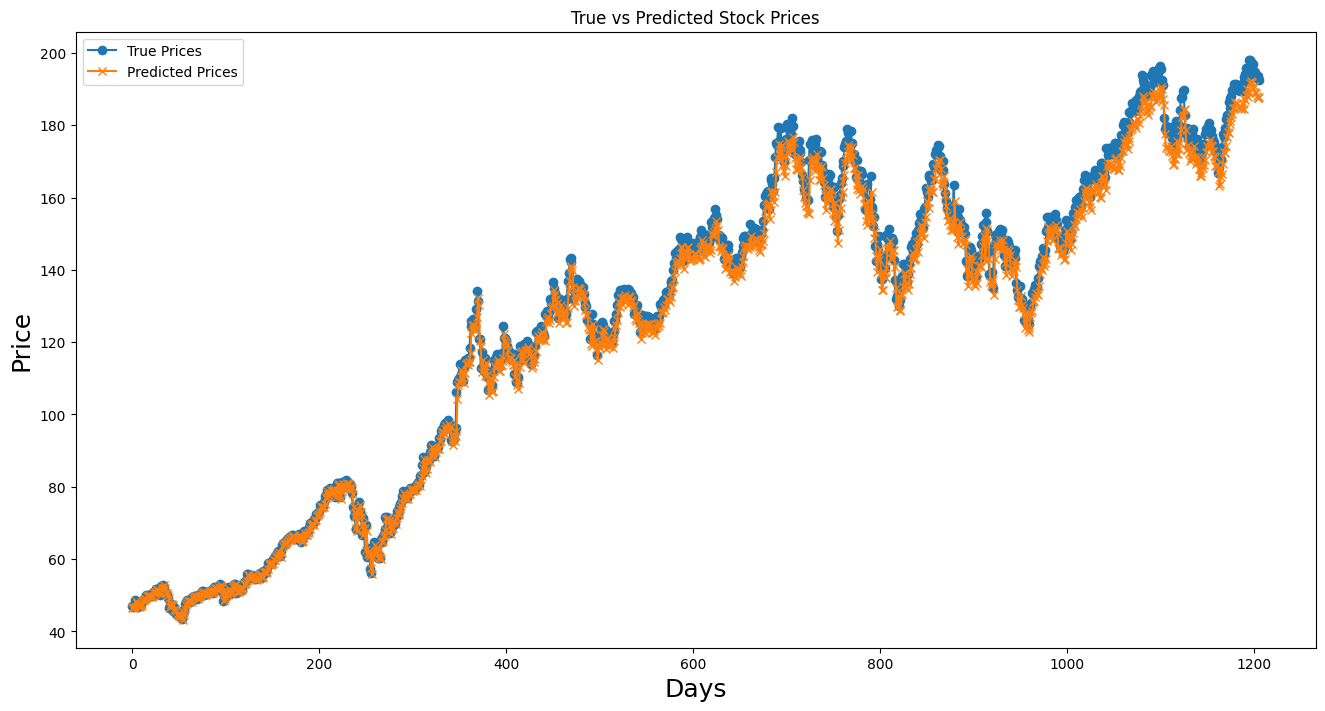

In [23]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calculate Mean Absolute Percentage Error (MAPE)
mape = mean_absolute_percentage_error(y_test, predictions)

print("Mean Absolute Percentage Error (MAPE):", mape)

# Plot the true prices and predicted prices
plt.figure(figsize=(16,8))
plt.plot(y_test, label='True Prices', marker='o')
plt.plot(predictions, label='Predicted Prices', marker='x')
plt.xlabel('Days',fontsize=18)
plt.ylabel('Price',fontsize=18)
plt.title('True vs Predicted Stock Prices')
plt.legend()
plt.show()



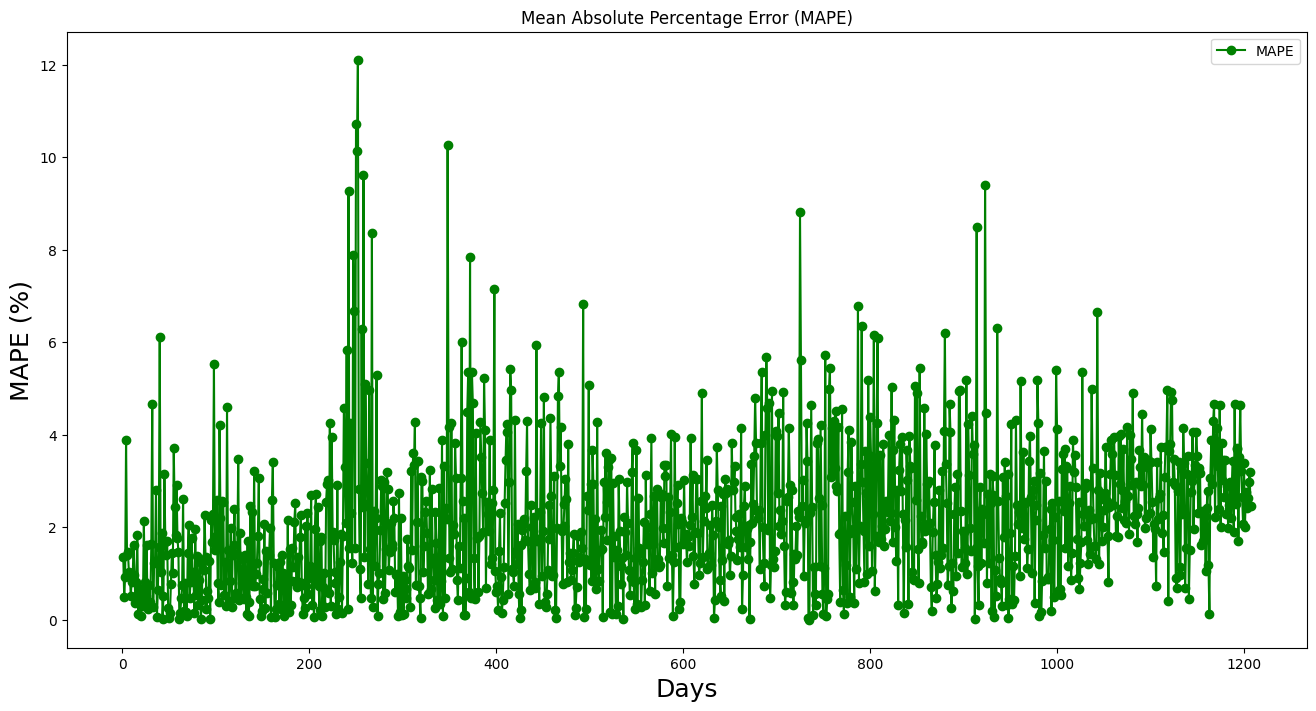

In [24]:
# Plot the Mean Absolute Percentage Error (MAPE)
plt.figure(figsize=(16,8))
plt.plot(np.arange(1, len(y_test) + 1), np.abs((np.array(y_test) - np.array(predictions)) / np.array(y_test)) * 100, label='MAPE', marker='o', color='green')
plt.xlabel('Days',fontsize=18)
plt.ylabel('MAPE (%)',fontsize=18)
plt.title('Mean Absolute Percentage Error (MAPE)')
plt.legend()
plt.show()

C:\Users\ASUS\AppData\Local\Temp\ipykernel_21872\1945113730.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


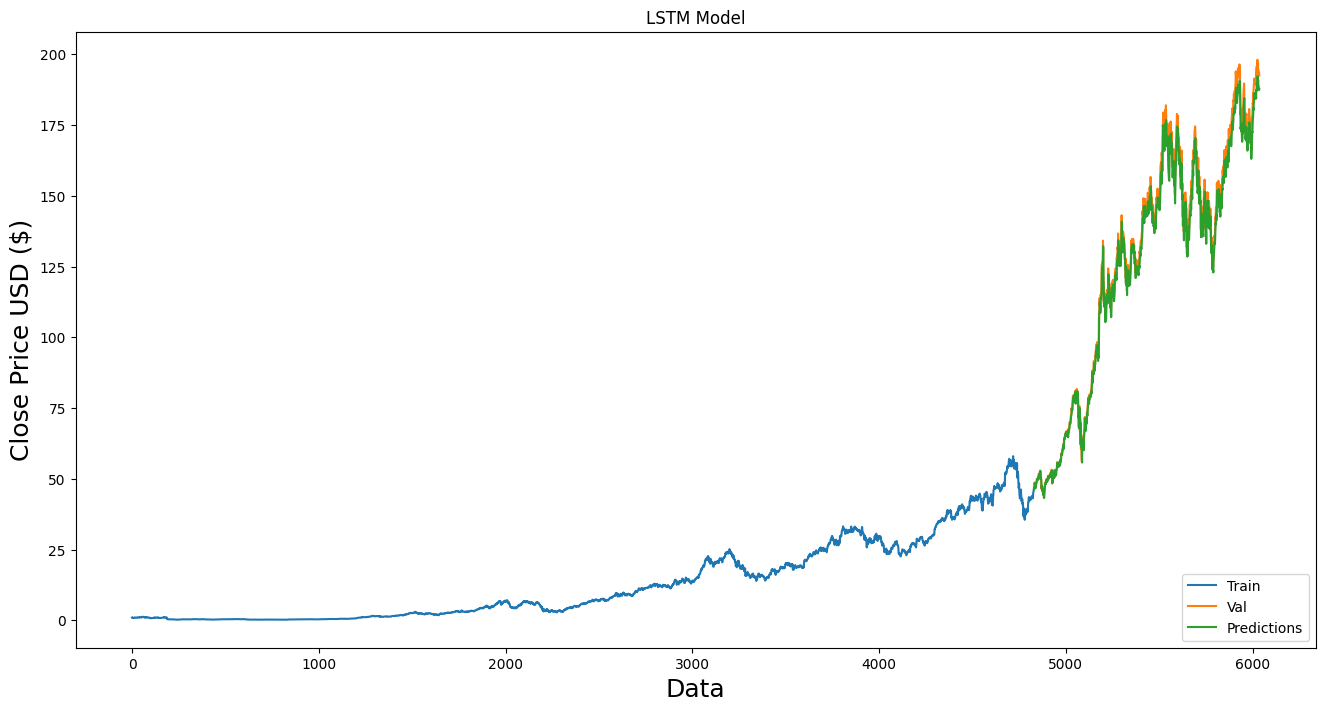

In [25]:
#Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
#Visualize the data
plt.figure(figsize=(16,8))
plt.title("LSTM Model")
plt.xlabel("Data",fontsize=18)
plt.ylabel("Close Price USD ($)",fontsize=18)
plt.plot(train["Close"])
plt.plot(valid[["Close",'Predictions']])
plt.legend(['Train','Val','Predictions'],loc = 'lower right')
plt.show()

In [26]:
#Show the valid and predicted prices
valid

,Close,Predictions
4830,47.005001,46.365887
4831,46.632500,46.858746
4832,47.040001,46.605572
4833,48.772499,46.871887
4834,47.762501,48.426487
...,...,...
6032,193.600006,188.903748
6033,193.050003,187.986038
6034,193.149994,187.391235
6035,193.580002,187.413071


In [27]:
#Get the quote
start = '2012-01-01'
end = datetime.datetime.now().date()
stock = 'AAPL'
df1 = yf.download(stock, start, end)
new_df = df1.filter(["Close"])
#Get the last 100 days closing price values and convert the dataframe to an array
last_100_days = new_df[-100:].values
#Scale the data to be values between 0 and 1
last_100_days_scaled = scaler.transform(last_100_days)
#Create an empty list
X_test = []
#Append the past 100 days
X_test.append(last_100_days_scaled)
#Convert the X_test data set to a numpy array
X_test = np.array(X_test)
#Reshape the data
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
#Get the preidcted scaled price
pred_price = model.predict(X_test)
#Undo the scaling
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)

[*********************100%%**********************]  1 of 1 completed

1/1 [==============================] - 0s 38ms/step
[[165.34618]]


In [28]:
#Get the quote
# start = datetime.datetime.now().date()
# end = datetime.datetime.now().date()
# stock = 'AAPL'
# df2 = yf.download(stock, start, end)
# print(df2["Close"])
model.save('Stock Price Prediction Model.keras')